# Fine-Tune BERT for Text Classification with TensorFlow

## Overview

In this project, we will use TensorFlow and TF-Hub to fine-tune a BERT model (BIRT: Bidirectional Embedding Representations from Transformers) for text classification. To train such a model, we mainly have to train the classifier, with minimal changes happening to the BERT model during the training phase. This training process is called Fine-Tuning, and has roots in Semi-supervised Sequence Learning and ULMFiT (https://jalammar.github.io/illustrated-bert/). 
We use a pre-trained BERT model that is [available](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2) on [TensorFlow Hub](https://tfhub.dev/). 

The objective of this project is to:
- Build TensorFlow Input Pipelines for Text Data with the [`tf.data`](https://www.tensorflow.org/api_docs/python/tf/data) API
- Tokenize and Preprocess Text for BERT
- Fine-tune BERT for text classification with TensorFlow 2 and [TF Hub](https://tfhub.dev)

For this project, we will be using a [data set](https://www.kaggle.com/c/quora-insincere-questions-classification) provided y **Quora** on  **Kaggle** to detect toxic online content to improve the quality of discussions and conversations we have online. **Quora**  is one of the well-known question and answering websites that provided this dataset as a competition on Kaggle. The data is labeled and contains questions asked on Quora and corresponding labels that indicate whether the question was insincere or not. Insincere questions are considered to be toxic, these questions can have a non-neutral tone, could be aggressive or disparaging, or inflammatory or based on false information, or containing sexual content for shock value and so on. If the question is insincere, it is labeled as 1, and a non-toxic question is labeled as 0.

There are some preprocessing steps that are required to get the raw input data to a format that BIRT accepts as input. However, luckily for us, the official TensorFlow models repositories has sub modules and tokenizers that do these preprocessing for us. So, we are not going to do any additional preprocessing manually, like lower casing, stemming, removing stop words and so on. Because, the module that we will be using from TensorFlow Hub along with the submodules and helper functions from the official model repository is going to take care of this for us.

To verify that we have GPU available, we can execute the folloing cell which show us basic information about our GPU.

In [1]:
!nvidia-smi

Mon Jan 10 19:51:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1. Install TensorFlow and TensorFlow Model Garden and Import Dependencies

In [2]:
import tensorflow as tf
print(tf.version.VERSION)

2.7.0


In [3]:
# if tf is not installed, use the following
!pip install -q tensorflow==2.7.0

In [3]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 2650, done.
remote: Counting objects: 100% (2650/2650), done.
remote: Compressing objects: 100% (2311/2311), done.
remote: Total 2650 (delta 506), reused 1388 (delta 306), pack-reused 0
Receiving objects: 100% (2650/2650), 34.02 MiB | 17.65 MiB/s, done.
Resolving deltas: 100% (506/506), done.
Note: checking out '400d68abbccda2f0f6609e3a924467718b144233'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>



In [4]:
# install requirements to use tensorflow/models repository
!pip install -Uqr models/official/requirements.txt

     |████████████████████████████████| 7.9 MB 13.3 MB/s 
     |████████████████████████████████| 205 kB 50.0 MB/s 
     |████████████████████████████████| 15.7 MB 43.4 MB/s 
     |████████████████████████████████| 11.3 MB 42.0 MB/s 
     |████████████████████████████████| 280 kB 34.5 MB/s 
     |████████████████████████████████| 99 kB 9.9 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
     |████████████████████████████████| 213 kB 53.3 MB/s 
     |████████████████████████████████| 4.0 MB 51.3 MB/s 
     |████████████████████████████████| 1.1 MB 42.7 MB/s 
     |████████████████████████████████| 352 kB 52.8 MB/s 
     |████████████████████████████████| 1.2 MB 39.9 MB/s 
     |████████████████████████████████| 1.9 MB 40.7 MB/s 
     |████████████████████████████████| 11.2 MB 22.1 MB/s 
     |████████████████████████████████| 47.7 MB 1.8 MB/s 
     |████████████████████████████████| 596 kB 51.2 MB/s 
     |████████████████████████████████| 4.3 MB 35.3 MB/s 
     |███████

In [1]:
# import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization


print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.7.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


## 2. Download and Import the Quora Dataset

You can download the dataset from https://www.kaggle.com/c/quora-insincere-questions-classification/data and use the path on your local computer to read the data into a pandas DataFrame and investigate it. A downloadable copy of the [Quora Insincere Questions Classification data](https://www.kaggle.com/c/quora-insincere-questions-classification/data) can be found [https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip](https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip).

In [2]:
df = pd.read_csv('https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip',
                 compression='zip', low_memory=False)

In [3]:
df.shape

(1306122, 3)

We can see that the dataset is huge and it take hours if we want to fine-tune BIRT on all of it. But, since BIRT is trained on a massive amount of data we only need to provide a small amount of data for fine-tuning. So, we are going to fine-tuning only on a very small fraction on the order of around 10,00 samples from training set and validation on 1000 samples.

In [4]:
# exploring the dataset
df.tail(20)

,qid,question_text,target
1306102,ffff3778790af9baae76,What steps can I take to live a normal life if...,0
1306103,ffff3f0a2449ffe4b9ff,Isn't Trump right after all? Why should the US...,1
1306104,ffff41393389d4206066,Is 33 too late for a career in creative advert...,0
1306105,ffff42493fc203cd9532,What is difference between the filteration wor...,0
1306106,ffff48dd47bee89fff79,"If the universe ""popped"" into existence from n...",0
1306107,ffff5fd051a032f32a39,How does a shared service technology team meas...,0
1306108,ffff6d528040d3888b93,How is DSATM civil engineering?,0
1306109,ffff8776cd30cdc8d7f8,Do you know any problem that depends solely on...,0
1306110,ffff94d427ade3716cd1,What are some comic ideas for you Tube videos ...,0
1306111,ffffa382c58368071dc9,"If you had $10 million of Bitcoin, could you s...",0


The dataset has three columns. The column `qid` does not have any predictive power, so we will drop it later. Then we have the questions column and the binary target. Let's see the distribution of class labels to know how the dataset looks like. In this way we can get an idea of an imbalanced data set. 

<AxesSubplot:title={'center':'Target Distribution'}, ylabel='Frequency'>

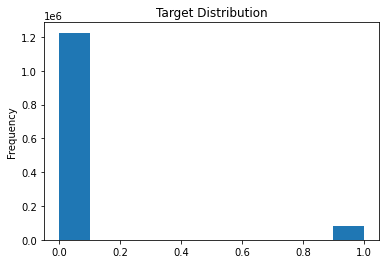

In [5]:
df.target.plot(kind='hist', title='Target Distribution')

This is a highly skewed graph where we have a clear imbalance problem such that the majority questions within this dataset are sincere, and we will have to account for this in the modeling process. There are many ways to address this problem; the approach we are going to be using is **stratified sampling**. So, in the next step, we will split the data for training and validation and by using stratify based on the target column.

## 3. Create tf.data.Datasets for Training and Evaluation

In [6]:
train_df, remaining = train_test_split(df, random_state=42, train_size=0.0075, stratify=df.target.values) # we want 75% of the data, about 10,000 samples
valid_df, _ = train_test_split(remaining, random_state=42, train_size=0.00075, stratify=remaining.target.values) # about 2000 samples for validation

train_df.shape, valid_df.shape 

((9795, 3), (972, 3))

GPUs and TPUs can radically reduce the time required to execute a single training step and acheiving peak performance requires an efficient input pipeline that delivers data for the next step before the current step has finished. The `tf.data` API helps us to build this flexible and efficient input pipeline.

During training many input elements need to be preprocessed; we need to convert them to the format of token ids, mask ids, and input type ids so that BIRT can accept them as an input. The `tf.data` API offers the `tf.data.Dataset` map transformation which applies a user defined function to each element of input dataset, and because input elements are independent from one another, the preprocessing step can be parallelized accross multiple CPU cores. To make this possible, the map transformation from `tf.data` API provides an argument where we can specify the level of parallelism that we want during preprocessing. So, what we can do is to do all the preprocessing on CPU and in that way there is no GPU overhead. 

To create an input pipeline, we must start with a data souurce. For example, to construct a dataset from data in memory we can use the `tf.data.Dataset.from_tensors` method, or the `tf.data.dataset.from_tensor_slices` method. And the return dataset object is a python iterable, which makes it possible to consume its elements using a for-loop.



In [7]:
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_df['question_text'].values, train_df['target'].values))
  valid_data = tf.data.Dataset.from_tensor_slices((valid_df.question_text.values, valid_df.target.values))

  for text, label in train_data.take(1): # we want to see only one sample
    print(text)
    print(label) 

tf.Tensor(b'Why are unhealthy relationships so desirable?', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


Now that we have created TensorFlow dataset for training and evaluation, we download the pre-trained BIRT model from TessorFlow-Hub and instantiate the tokenizer that will take care of tokenizing the text and preprocessing it in the next section.

## 4. Download a Pre-trained BERT Model from TensorFlow Hub

In [8]:
"""
Each line of the dataset is composed of the review text and its label
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
"""

label_list = [0, 1]  # Label categories
max_seq_length = 128   # maximum length of (token) input sequences (BIRT is limited to 512)
train_batch_size = 32


# Get BERT layer and tokenizer:
# More details here: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2
bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2', trainable=True) # we set trainable to True to fine tune all the hyper parameters.

# instantiate tokenizer
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [9]:
# example
tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing today?')

['hi', '##,', 'how', 'are', 'you', 'doing', 'today', '##?']

In [10]:
# converting to token ids that BIRT requires
tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing today?'))

[7632, 29623, 2129, 2024, 2017, 2725, 2651, 29632]

This is not the full story. We know that each sentence or sequence contains two special tokens. So, once the sentence is tokenized into token ids like above, we will need to prepend a start token clled `CLS` that has a constant value of `101`, and we need to append a seperator token called `SEP` at the end of sequence that has a constant value of `102`. At this point, our token tensors have different length but in TensorFlow all the tensors need to have the same length, specially for the BIRT model. So, we need padding each one of the tensors untill they are the max sequence length. Luckilly, we do not need to do these additional steps, we can leverage the submodules we cloned from the official TensorFlow model repository.

## 5. Tokenize and Preprocess Text for BERT

We'll need to transform our data into a format BERT understands. This involves two steps. First, we create InputExamples using `classifier_data_lib`'s constructor `InputExample` provided in the BERT library.

In [11]:
# This provides a function to convert row to input features and label

def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  example = classifier_data_lib.InputExample(guid=None,
                                             text_a = text.numpy(),
                                             text_b = None,
                                             label = label.numpy())
  # converting the example into features
  feature = classifier_data_lib.convert_single_example(0, example, label_list, max_seq_length, tokenizer) # 0 is the index of the one example

  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)
  


# guid: the unique id for each example. Since we are working with one example at the time, we set it as None.
# text_a: this the test we want to classify which is in tensor format and we need to get the value of that tensor and we call the .numpy() function on that
# text_b: if we were doing a next sentence prediction, we use this arument. But since we are doing one text at a time, we set it to None.
# label: we need  to pass a lable for the example

We cannot directly use this function to create our input data structure. We need to use the `tf.data.Dataset.map` function to apply the function that we just created to each element of our dataset. However, the problem is that `Dataset.map` runs in graph mode, and this is a problem because graph tensors do not have a value. In graph mode you can only use TensorFlow Ops and functions. So, we cannot map the function that we wrote directly to our date and we need to wrap it in a TensorFlow python function class. This will create a wrapper function so that rather than using graph tensors that do not have a value, we pass in regular tensors with a value and a `.numpy()` method so that it is accessible.


You want to use [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) to apply this function to each element of the dataset. [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) runs in graph mode.

- Graph tensors do not have a value.
- In graph mode you can only use TensorFlow Ops and functions.

So you can't `.map` this function directly: You need to wrap it in a [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function). The [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function) will pass regular tensors (with a value and a `.numpy()` method to access it), to the wrapped python function.

## 6. Wrap a Python Function into a TensorFlow op for Eager Execution

In [12]:
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text, label], 
                                                                Tout=[tf.int32, tf.int32, tf.int32, tf.int32]) # Tout: tensor output type
  input_ids.set_shape([max_seq_length]) 
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])

  x = {
      'input_word_ids': input_ids,
       'input_mask': input_mask,
       'input_type_ids': segment_ids
  }

  return (x, label_id)

Now that we created our TensorFlow dataset and the function that maps the raw text into the format that BIRT requires, all we need to do is to map our dataset into this function.

## 7. Create a TensorFlow Input Pipeline with `tf.data`

Now, we are going to use the `tf.data.Dataset.map` function to glue everything together. This function applys per element transformations to the dataset, so we can use the `Dataset.map` function to do it per element and we can also add a `.batch` function to do it to apply the transformations on batch of elements.

In [13]:
with tf.device('/cpu:0'):
  # train
  train_data = (train_data.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
                              .shuffle(1000)
                              .batch(32, drop_remainder=True)
                              .prefetch(tf.data.experimental.AUTOTUNE))
  

  # valid
  valid_data = (valid_data.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
                              .batch(32, drop_remainder=True)
                              .prefetch(tf.data.experimental.AUTOTUNE))


# num_parallel_calls: since input elements are independent from each other, the preprocessing can be parallelized and we let tf to decide the number of optimum proccessors to use
# shuffle and batch: we are going to shuffle our data and then batch it. we defined batch size as 32 before. And if we have more examples than the batch size we drope them to 
# make all the batch sizes equal.
# prefetch: prefetching is an optimization step that overlaps preprocessing and the model execution of a training step. So, while the model executing a training step n, 
# the input pipeline is reading data for step n+1, and doing so reduces the step time to the maximum.


The resulting `tf.data.Datasets` return `(features, labels)` pairs, as expected by [`keras.Model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit):

In [14]:
# train data specification
train_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [15]:
# valid data specification
valid_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

## 8. Add a Classification Head to the BERT Layer

We now have our input data. All we need to do now is define our classification model. With the BIRT layaer from the tf-hub we can pass in out token ids, input ids, the input type ids to our BIRT layer and it is going to give us two outputs: a pooled_output of shape [batch_size, 768] with representations for the entire input sequences and a sequence_output of shape [batch_size, max_seq_length, 768] with representations for each input token (in context)

In [16]:
# Building the model
def create_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
  input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="input_type_ids")
  
  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])

  # if we want we can add some dense layare here, but for the sake of simlisity, we will add some dropout regularization to try to minimize overfitting on the training set.
  drop = tf.keras.layers.Dropout(0.4)(pooled_output)
  output = tf.keras.layers.Dense(1, activation="sigmoid", name="output")(drop) # it's a binary classification, so we have 1 unit of sigmond function

  model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': input_type_ids
    },
    outputs=output)
  return model

## 9. Fine-Tune BERT for Text Classification

Now, we just need to call the function we defined above to create our model and then compile the model. And after these two steps, we can fit the model by `model.fit` method on our data.

In [17]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()

# we are choosing a very low learning rate to prevent overfitting since the model is over parametrized.
# it's a binary classification, so the loss function will be binary crossentropy. If we are doing multi class classification with more labels,
# we can use sparse categorical crossentropy. We are not using categorical crossentropy directly because we have not on-hot encoded our labels.
# And we use binary accuracy as a metric. Since this is an imbalance classification problem, accuracy is not the best metric, but for the sake of simplicity we use it.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 128, 768)]                'input_mask[0][0]',         

As you can see, we have our **input_word_ids**, **input_mask**, and **input_type_ids**, this is fed into a keras layer afer which we have our dropout regularization layer followed by one Sigmoid unit for classification. To illustrate the above infromation, we can use keras utility called `.plot_model`.

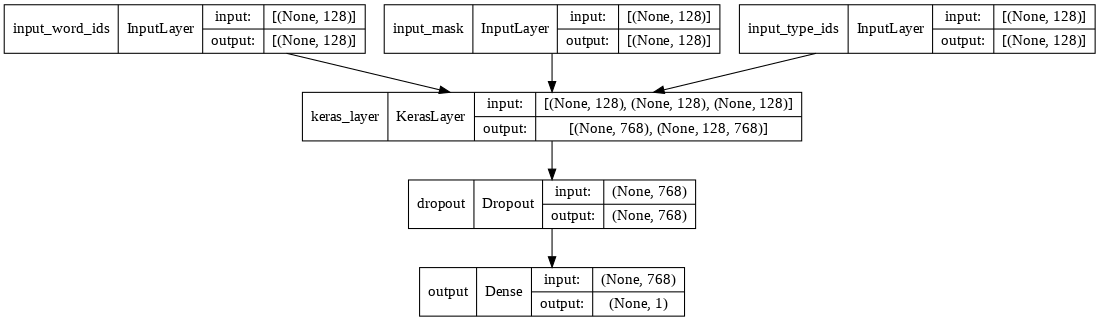

In [18]:
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=76, )

The above model architecture is not very accurate, because one drawback of using `tf.hub` is that it condenses the entire transformer or BIRT model into one layer and we cannot see the details inside it. We can say that the above is a general form of how our model is defined.

Now it is time to feed our model into our data.

In [19]:
# Train model
# since we are fine-tunning, we can fine-tune for X number of epochs before it starts overfitting
epochs = 4
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=epochs,
                    verbose=1) # we set it to 1 because we do not want a lot of output to be generated

Epoch 1/4
306/306 [==============================] - 515s 2s/step - loss: 0.1985 - binary_accuracy: 0.9307 - val_loss: 0.1225 - val_binary_accuracy: 0.9563
Epoch 2/4
306/306 [==============================] - 501s 2s/step - loss: 0.1010 - binary_accuracy: 0.9631 - val_loss: 0.1350 - val_binary_accuracy: 0.9604
Epoch 3/4
306/306 [==============================] - 501s 2s/step - loss: 0.0571 - binary_accuracy: 0.9810 - val_loss: 0.1568 - val_binary_accuracy: 0.9604
Epoch 4/4
306/306 [==============================] - 501s 2s/step - loss: 0.0308 - binary_accuracy: 0.9903 - val_loss: 0.1988 - val_binary_accuracy: 0.9365


From the above numbers we can see that we are still overfitting on our training dataset, we start overfitting from the second epoch. Given all other things constant, maybe we should have trained for fewer epochs, 2 or 3 epochs, or we could modify our model architecture, adding more regularizations, we can experiment with the number of layers we are using, and so on.

## 10. Evaluate the BERT Text Classification Model

In [20]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

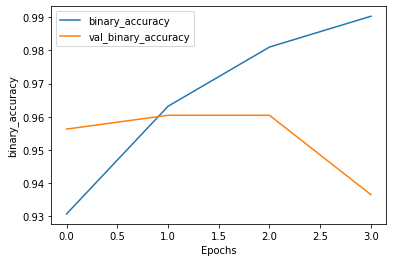

In [21]:
plot_graphs(history, 'binary_accuracy')

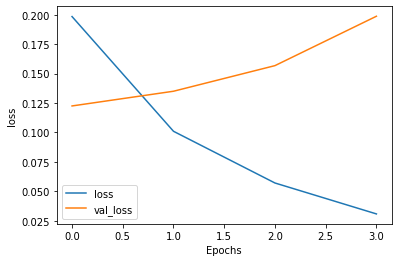

In [22]:
plot_graphs(history, 'loss')

Based on the graphs we can see that we are overfitting on our training data. This is one of the challenges of using BIRT, to figure out how not to overfit.

In [23]:
model.evaluate(valid_data, verbose=1)

30/30 [==============================] - 17s 562ms/step - loss: 0.1988 - binary_accuracy: 0.9365


[0.19877709448337555, 0.9364583492279053]

The following is an example of how we can use our model to evaluate if a question is sincere or not.

In [24]:
sample_example = ["do you think that can help others?",\
                  "why do people think they know everything?",\
                  "may I ask you some personal questions?",\
                  "what is your phone number?",\
                  "do you beleive in God?",\
                  "this is stupid, why are you supporting this?"]
test_data = tf.data.Dataset.from_tensor_slices((sample_example, [0]*len(sample_example)))
test_data = (test_data.map(to_feature_map).batch(1))
preds = model.predict(test_data)
['Toxic' if pred >=0.5 else 'Sincere' for pred in preds]

['Sincere', 'Toxic', 'Sincere', 'Sincere', 'Sincere', 'Toxic']

In [25]:
preds

array([[2.8941460e-04],
       [9.1969085e-01],
       [4.5977419e-04],
       [3.3646409e-04],
       [7.0633995e-04],
       [9.5731437e-01]], dtype=float32)